## 1 | Imports

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from functions import *
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder, Normalizer, MinMaxScaler
from sklearn import preprocessing
import scipy.stats as stats

warnings.filterwarnings('ignore')

## 2 | Working on the dataset

### Cleaning the data

In [2]:
rent_df = pd.read_csv('/Users/ignaciolorenzoqueralt/Documents/Ironhack/Final Project/properties/rent/2021.11.08_cataluña_900_30.csv', engine='python' )
rent_df = rent_df.loc[:, ~rent_df.columns.str.contains('^Unnamed')]

In [3]:
rent_df.head(3)

,name,area,neighborhood,geo_town,m2,n_rooms,n_bath,price_m2,price,price_reduction,opportunity,last_update,description,url,province,ccaa
0,Alquiler Apartamento N ii junquera. Alquiler ...,Arenys de Mar,Urbanitzacions,arenys_de_mar,70.0,3.0,1.0,14.0,980.0,120.0,yes,6.0,INMUEBLE NO SUJETO A LA LIMITACIÓN DE PRECIOS ...,https://www.habitaclia.com/alquiler-apartament...,barcelona,cataluña
1,"Alquiler Piso en Carrer mig (del), 20. Vivie...",Arenys de Mar,Urbanitzacions,arenys_de_mar,89.0,2.0,1.0,7.0,680.0,20.0,no,9.0,Vivienda en la Urbanización Carolines de Areny...,https://www.habitaclia.com/alquiler-piso-vivie...,barcelona,cataluña
2,Alquiler Apartamento Carrer camí ral del caba...,Arenys de Mar,Urbanitzacions,arenys_de_mar,70.0,3.0,1.0,14.0,980.0,10.0,no,8.0,ALQUILER DE TEMPORADA - Bonito piso de 70 m2 t...,https://www.habitaclia.com/alquiler-apartament...,barcelona,cataluña


In [4]:
rent_df.shape

(3428, 16)

In [5]:
rent_df = rent_df.dropna()

In [6]:
clean_last_update(rent_df, c = 'last_update')

In [7]:
checking_nulls(rent_df)

,name,area,neighborhood,geo_town,m2,n_rooms,n_bath,price_m2,price,price_reduction,opportunity,last_update,description,url,province,ccaa


In [8]:
rent_df.shape

(2429, 16)

In [9]:
numericals = ['m2', 'n_rooms', 'n_bath', 'price_m2', 'price', 'price_reduction', 'last_update']
convet_to_numerical(rent_df, numericals)

In [10]:
rent_df.dtypes

name               object
area               object
neighborhood       object
geo_town           object
m2                  int64
n_rooms             int64
n_bath              int64
price_m2            int64
price               int64
price_reduction     int64
opportunity        object
last_update         int64
description        object
url                object
province           object
ccaa               object
dtype: object

Filtering out towns in which there are less than x properties listed.

In [11]:
filtered_towns = list(rent_df['geo_town'].value_counts()[lambda x: x > 30].index)
rent_df_filtered = rent_df[rent_df['geo_town'].isin(filtered_towns)]
rent_df_filtered.shape

(1762, 16)

### Feature selection

We skip neighborhood as it would add too many distinct categorical values which would increase too much the size of the model when encoding it.

In [12]:
model_df = rent_df_filtered[['m2', 'n_rooms', 'n_bath', 'opportunity', 'last_update', 'geo_town', 'province', 'ccaa', 'price']].copy()

In [13]:
model_df.head(3)

,m2,n_rooms,n_bath,opportunity,last_update,geo_town,province,ccaa,price
31,65,2,1,no,3,badalona,barcelona,cataluña,906
32,75,3,1,no,23,badalona,barcelona,cataluña,900
33,41,1,1,no,11,badalona,barcelona,cataluña,725


### Visualizing the original dataset

opportunity
no     98.2
yes     1.8
Name: opportunity, dtype: float64


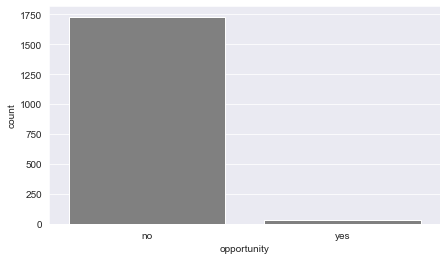

geo_town
barcelona                  58.4
terrassa                    6.6
hospitalet_de_llobregat     5.5
sabadell                    5.4
tarragona                   5.1
manresa                     3.6
mataro                      3.5
reus                        2.9
badalona                    2.7
sitges                      2.5
granollers                  2.2
rubi                        1.8
Name: geo_town, dtype: float64


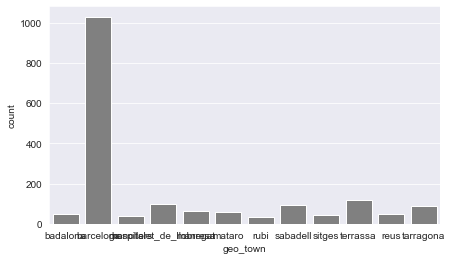

province
barcelona    92.1
tarragona     7.9
Name: province, dtype: float64


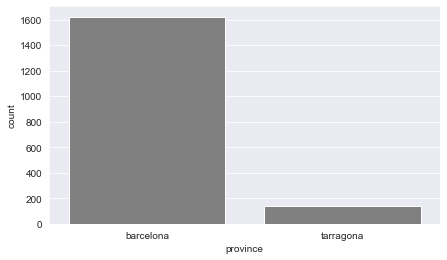

ccaa
cataluña    100.0
Name: ccaa, dtype: float64


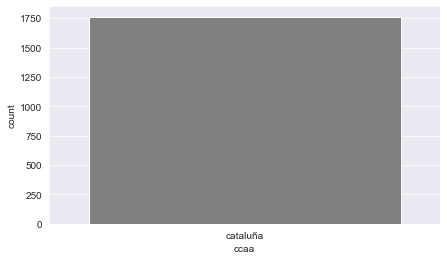

In [14]:
cat_exploration(model_df)

## 3 | Model

In [15]:
X = model_df[['m2', 'n_rooms', 'n_bath', 'opportunity', 'last_update', 'geo_town', 'province', 'ccaa']].copy()
y = model_df[['price']].copy()

In [16]:
X_cat = X.select_dtypes('object')
X_num = X.select_dtypes('int')

In [17]:
X_cat_enc = pd.get_dummies(X_cat, drop_first=True)

In [18]:
X_num

,m2,n_rooms,n_bath,last_update
31,65,2,1,3
32,75,3,1,23
33,41,1,1,11
34,81,2,1,3
35,25,1,1,3
...,...,...,...,...
3371,62,3,1,6
3372,70,3,1,2
3373,65,4,1,6
3376,93,3,2,6


In [19]:
def boxcox_transform(df):
    numeric_cols = df.select_dtypes(np.number).columns
    _ci = {column: None for column in numeric_cols}
    for column in numeric_cols:
        df[column] = np.where(df[column]<=0, np.NAN, df[column]) 
        df[column] = df[column].fillna(df[column].mean())
        transformed_data, ci = stats.boxcox(df[column])
        df[column] = transformed_data
        _ci[column] = [ci] 
    return df, _ci

X_num_norm, _ci = boxcox_transform(X_num)
X_num_norm.shape, X_cat_enc.shape

((1762, 4), (1762, 13))

In [20]:
scaler = preprocessing.MinMaxScaler()
names = X_num.columns
X_num = scaler.fit_transform(X_num)
X_num_scaled = pd.DataFrame(X_num, columns=names)
X_num_scaled.head()

,m2,n_rooms,n_bath,last_update
0,0.530394,0.338043,0.0,0.317433
1,0.584619,0.595209,0.0,0.812827
2,0.370859,0.000000,0.0,0.646206
3,0.614764,0.338043,0.0,0.317433
4,0.222555,0.000000,0.0,0.317433


In [21]:
X_num_norm

,m2,n_rooms,n_bath,last_update
31,8.360479,0.823570,0.000000,1.034350
32,8.875372,1.450100,0.000000,2.648586
33,6.845614,0.000000,0.000000,2.105655
34,9.161613,0.823570,0.000000,1.034350
35,5.437387,0.000000,0.000000,1.034350
...,...,...,...,...
3371,8.195279,1.450100,0.000000,1.625037
3372,8.624354,1.450100,0.000000,0.667187
3373,8.360479,1.975385,0.000000,1.625037
3376,9.692400,1.450100,0.133264,1.625037


In [22]:
X_num_scaled

,m2,n_rooms,n_bath,last_update
0,0.530394,0.338043,0.000000,0.317433
1,0.584619,0.595209,0.000000,0.812827
2,0.370859,0.000000,0.000000,0.646206
3,0.614764,0.338043,0.000000,0.317433
4,0.222555,0.000000,0.000000,0.317433
...,...,...,...,...
1757,0.512997,0.595209,0.000000,0.498709
1758,0.558184,0.595209,0.000000,0.204753
1759,0.530394,0.810818,0.000000,0.498709
1760,0.670663,0.595209,0.994358,0.498709


In [23]:
X = np.concatenate([X_num_scaled, X_cat_enc], axis=1)

In [24]:
X.shape

(1762, 17)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [26]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [27]:
predictions = model.predict(X_test)
r2 = r2_score(y_test, predictions)
print(r2)

0.48320125342646547
